In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import griddata
import math
from scipy.signal import decimate, convolve

Debug = 0

In [2]:
RawData = "rawdata/probeX.data"
f = open(RawData, "r")
a = np.fromfile(f, dtype=np.uint32)
t = a[-1]
V = a[:-1].copy()
T = [ (( x * t ) / ( 1000.0*len(V) )) for x in 2*range(len(V))]
Tt = [ (( x * t ) / ( 1000.0*len(V) )) for x in range(len(V))]
Fech = 1000.0*len(V)/t # in MHz

In [3]:
#ADC1_pins = [21,22,19,15,13,11,12,10, 8]
ADC1_pins = [21,22,19,15,13,11,12,10, 8]
ADC2_pins = [38,37,36,35,33,32,26,24,23]

#ADC1_GPIO = [9, 25,10,22,27,17,18,15,14]
ADC1_GPIO =  [9 ,25,10,22,27,17,18,15,14]
ADC2_GPIO = [20,26,16,19,13,12, 7, 8,11]

ADC1len = len(ADC1_GPIO)
ADC2len = len(ADC2_GPIO)


def MoreInfos(Volts):
    PWM = []
    GPIO21 = []
    for i in range(len(Volts)):
        val = int(V[i])
        GPIO21.append(150*(val & 2**21)/2**21)
        PWM.append(150*(val & 2**6)/2**6)
            
    return PWM,GPIO21

def GetV2(Volts):
    Signal = []
    Map = np.zeros((len(V),ADC2len), dtype=np.int)
    for i in range(len(Volts)):
        val = int(V[i])
        SignalZero = 0
        for k in range(ADC2len):
            Map[i][k] = (val & 2**k)/2**k
        for k in range(ADC2len):
            SignalZero += 2**k*((val & 2**ADC2_GPIO[k])/2**ADC2_GPIO[k])
        Signal.append(SignalZero)

            
    return Signal,Map



def GetV1(Volts):
    Signal = []
    Map = np.zeros((len(V),ADC1len), dtype=np.int)
    for i in range(len(Volts)):
        val = int(V[i])
        SignalZero = 0
        for k in range(ADC1len):
            Map[i][k] = (val & 2**k)/2**k
        for k in range(ADC1len):
            SignalZero += 2**k*((val & 2**ADC1_GPIO[k])/2**ADC1_GPIO[k])
        Signal.append(SignalZero)

            
    return Signal,Map

In [4]:
PWM,GPIO21 = MoreInfos(V)

In [6]:
M = GetV2(V)[0]
M2 = GetV1(V)[0]
Ma = M - np.average(M)
Mb = M2 - np.average(M2)
rawSig = []
for k in range(len(Ma)):
    rawSig.append(Mb[k])
    rawSig.append(Ma[k])

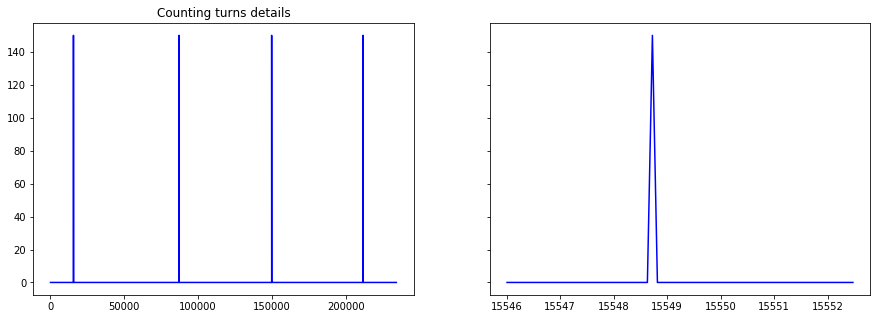

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,5))
ax1.plot(Tt,GPIO21,"b")
ax1.set_title('Counting turns')
ax2.plot(Tt[165950:166020],GPIO21[165950:166020],"b")
ax1.set_title('Counting turns details')
plt.show()

In [8]:
BeginningLines = [2*x/5000 for x in np.nonzero(GPIO21)][0]

In [9]:
FFT = np.fft.fft(rawSig)
FFTCleaned = np.fft.fft(rawSig)
FStart = 0.068*len(FFTCleaned)
FStop = 0.196*len(FFTCleaned)
for k in range(len(FFTCleaned)/2):
    if (k < FStart or k > FStop): # in (k < 550000 or k > 790000) # 0.068 0.196
        FFTCleaned[k] = 0
        FFTCleaned[-k] = 0
    
Scale = max(FFT)
ff = [ Fech*2.0*x/(2*len(V)) for x in range(len(V))]

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


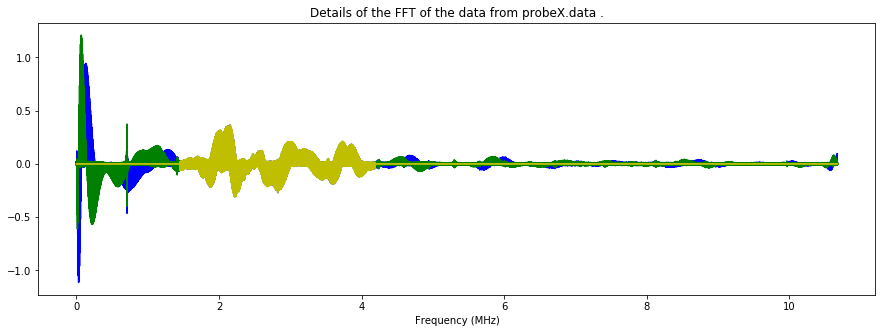

In [10]:
plt.figure(figsize=(15,5))
plt.plot(ff,np.real(FFT)[0:len(FFT)/2]/Scale,"b")
plt.plot(ff,np.imag(FFT)[0:len(FFT)/2]/Scale,"g")
plt.plot(ff,np.imag(FFTCleaned)[0:len(FFT)/2]/Scale,"y")
plt.plot(ff,np.real(FFTCleaned)[0:len(FFT)/2]/Scale,"y")
plt.title("Details of the FFT of the data from "+RawData.split("/")[-1]+" .")  
plt.xlabel("Frequency (MHz)")
plt.savefig('Imgs/fft_'+RawData.split("/")[-1]+".jpg", bbox_inches='tight')
plt.show()

In [11]:
F = np.real(np.fft.ifft(FFTCleaned))
FH = np.asarray(np.abs(signal.hilbert(F)))

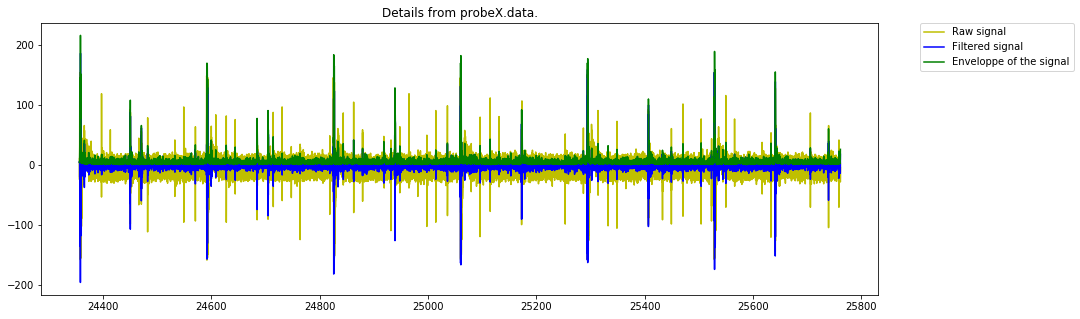

In [12]:
IndexEmpty = 20
IndexLine = 104
tt = IndexLine*2500
plt.figure(figsize=(15,5))
TT = np.divide(T,2.0)
plt.plot(TT[2*tt:2*tt+2*15000],rawSig[2*tt:2*tt+2*15000],"y", label='Raw signal')
plt.plot(TT[2*tt:2*tt+2*15000],np.real(np.fft.ifft(FFTCleaned))[2*tt:2*tt+2*15000],"b", label='Filtered signal')
plt.plot(TT[2*tt:2*tt+2*15000],FH[2*tt:2*tt+2*15000],"g", label='Enveloppe of the signal')
plt.title("Details from "+RawData.split("/")[-1]+".")  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('Imgs/datas_'+RawData.split("/")[-1]+'.jpg', bbox_inches='tight')
plt.show()

In [13]:
tableData = np.asarray(FH).reshape((1000,2*2500))
tableDataRaw = np.asarray(rawSig).reshape((1000,2*2500))

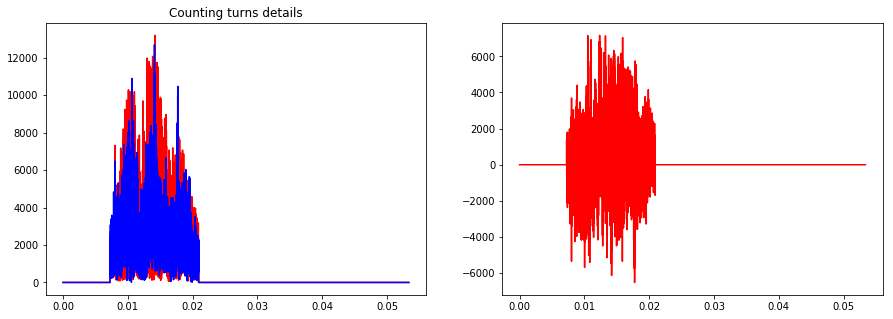

In [14]:
EmptyLine = rawSig[5000*IndexEmpty:5000*IndexEmpty+25000]
FullLine = rawSig[5000*IndexLine:5000*IndexLine+25000]
FFul = np.fft.fft(FullLine)
FFem = np.fft.fft(EmptyLine)
for i in range(len(FullLine)/2):
    if (i < 1700 or i > 4900):
        FFul[i] = 0
        FFem[i] = 0
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(ff[0:len(FullLine)/2],np.abs(FFul)[0:len(FullLine)/2],"r")
ax1.plot(ff[0:len(FullLine)/2],np.abs(FFem)[0:len(FullLine)/2],"b")
ax1.set_title('Counting turns')

ax1.set_title('Counting turns details')
diff = np.abs(FFul) - np.abs(FFem)
ax2.plot(ff[0:len(FullLine)/2],diff[0:len(FullLine)/2],"r")
plt.show()

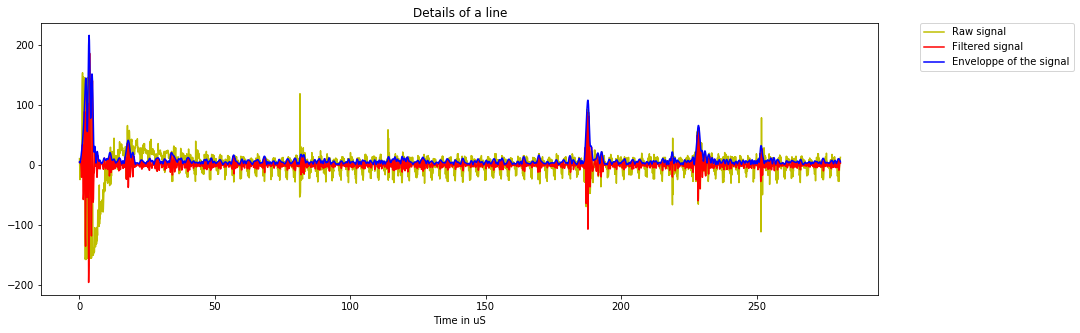

In [15]:
ExLine = tableData[IndexLine]
ExLineRaw = tableData[IndexLine]
plt.figure(figsize=(15,5))
plt.plot(T[0:3000],rawSig[5000*IndexLine:5000*IndexLine+3000],"y", label='Raw signal')
plt.plot(T[0:3000],F[5000*IndexLine:5000*IndexLine+3000],"r", label='Filtered signal')
plt.plot(T[0:3000],ExLine[0:3000],"b", label='Enveloppe of the signal')
plt.title("Details of a line")
plt.xlabel("Time in uS")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('Imgs/ProcessingLine_'+RawData.split("/")[-1]+".jpg", bbox_inches='tight')
plt.show()

In [54]:
Val = np.average(tableData)
tableData = np.asarray(FH).reshape((1000,2*2500))
Offset = 400
MinTable = 10*np.min(tableData)
Zeroes = np.zeros((1000,Offset))+Val
BigTable = []
BigTable = np.append(Zeroes, tableData, axis=1)

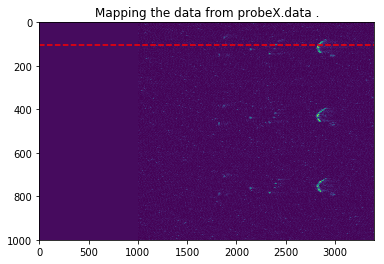

In [55]:
tableData = BigTable[:,:3000+Offset]
plt.imshow((abs(tableData)), aspect='auto')
plt.axhline(IndexLine, color='r', linestyle='--')
plt.title("Mapping the data from "+RawData.split("/")[-1]+" .")  
plt.savefig('Imgs/map_'+RawData.split("/")[-1]+".jpg", bbox_inches='tight')
plt.show()

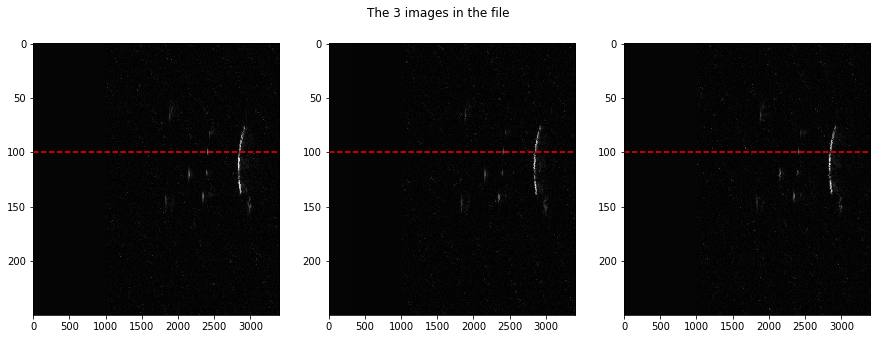

In [56]:
ListOfPoints= [104, 418, 741]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

TmpImg = (abs(tableData[ListOfPoints[0]-100:ListOfPoints[0]+150]))**(1.1)
ax1.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
ax1.axhline(100, color='r', linestyle='--')
TmpImg = (abs(tableData[ListOfPoints[1]-100:ListOfPoints[1]+150]))**(1.1)
ax2.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
ax2.axhline(100, color='r', linestyle='--')
TmpImg = (abs(tableData[ListOfPoints[2]-100:ListOfPoints[2]+150]))**(1.1)
ax3.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
ax3.axhline(100, color='r', linestyle='--')
plt.suptitle('The 3 images in the file')
plt.savefig('Imgs/images_'+RawData.split("/")[-1]+".jpg", bbox_inches='tight')
#plt.savefig('Imgs/mapCleanImage_'+RawData.split("/")[-1]+str(Start)+"-"+str(Stop)+".jpg", bbox_inches='tight')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in power


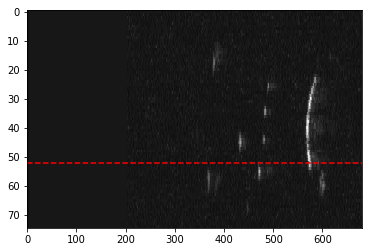

In [76]:
DecImg = []
for i in range(150):
    tmp = decimate(tableData[ListOfPoints[0]-70+i], 5, ftype='fir')
    tmp += decimate(tableData[ListOfPoints[1]-70+i], 5, ftype='fir')
    tmp += decimate(tableData[ListOfPoints[2]-70+i], 5, ftype='fir')
    DecImg.append(tmp)
#SmallImg = DecImg
SmallImg = []
for i in range(len(DecImg)/2):
    SmallImg.append((DecImg[2*i]+DecImg[2*i+1])/2)

plt.axhline(IndexLine/2, color='r', linestyle='--')

plt.imshow(np.asarray(SmallImg)**(0.7),cmap=plt.get_cmap('gray'), aspect='auto')
plt.savefig('Imgs/CompiledImage_'+RawData.split("/")[-1]+".jpg", bbox_inches='tight')
plt.show() 

In [62]:
def CreateSC(RawImgData):
    LenLinesC = np.shape(RawImgData)[1]
    NbLinesC = np.shape(RawImgData)[0]
    SC = np.zeros((LenLinesC,LenLinesC))+Val
    SC += 1
    maxAngle = 60.0
    step = maxAngle/(NbLinesC+1)
    CosAngle = math.cos(math.radians(30))
    Limit = LenLinesC*CosAngle

    points = []
    values = []

    for i in range(LenLinesC):
        for j in range(LenLinesC):
            if (  (j > LenLinesC/2 + i/(2*CosAngle)) or  (j < LenLinesC/2 - i/(2*CosAngle)) ):
                SC[i][j] = 0
                points.append([i,j])
                values.append(0)
            if (  (i > Limit) ):
                if ( (i**2 + (j-LenLinesC/2) ** 2) > LenLinesC**2):
                    SC[i][j] = 0 
                    points.append([i,j])
                    values.append(0)
    for i in range(NbLinesC):
        PointAngle = i*step-30
        COS = math.cos(math.radians(PointAngle))
        SIN = math.sin(math.radians(PointAngle))
        for j in range(LenLinesC):

            X = (int)( j*COS)
            Y = (int)(LenLinesC/2 - j*SIN)
            SC[X][Y] = RawImgData[i][j]
            points.append([X,Y])
            values.append(RawImgData[i][j])

    values = np.array(values,dtype=np.int)
    
    return SC,values,points,LenLinesC

In [77]:
if not(Debug):
    SCH,valuesH,pointsH,LenLinesCH = CreateSC(SmallImg)
    grid_xH, grid_yH = np.mgrid[0:LenLinesCH:1, 0:LenLinesCH:1]
    grid_z1H = griddata(pointsH, valuesH, (grid_xH, grid_yH), method='linear')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()


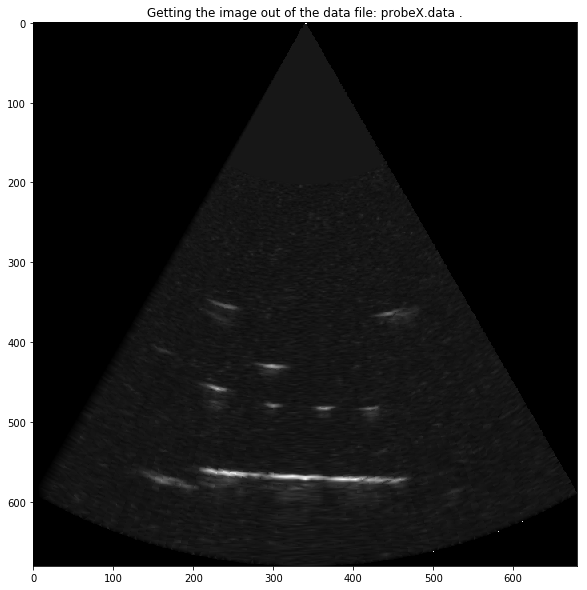

In [78]:
if not(Debug):
    plt.figure(figsize=(10,10))
    plt.imshow((grid_z1H**0.7),cmap=plt.get_cmap('gray')) 
    plt.title("Getting the image out of the data file: "+RawData.split("/")[-1]+" .")  
    plt.savefig('Imgs/pic_'+RawData.split("/")[-1]+".jpg", bbox_inches='tight')
    plt.show()